In [25]:
using IJulia, Plots, Printf

# Steady 1D Shallow Water equations

The purpose of this jupyter notebook is to provide a public and free usable stable implementation of the solution of the steady 1D SWE, first adopting a fixed bad approach and then moving to the mobile bed.

## Problem definition
First of all the definition of the problem is required, as well as the equations that will be solved.  
The problem consists in a (wide) rectangular channel, that can present steps, gates, localized narrowing or whatever along its longitudinal direction. The same solution could be performed for any prismatic channel, the choice of rectangular shape is done just for simplicity purposes. 
The situation in a section is depicted in the figure, at the same time the foundamental definitions referst to the image:  
  
![Problem description](images/problem_definition.svg)
  
The image shows a genelar section for which the following quantities are defined:
- d: water depth $[m]$;
- h: water level $[m]$;
- z: bed elevation (fixed) $[m]$;
- $kin:= \alpha \frac{U}{2g}$ $[m]$: the kinetic term of the energy;
- $H = h + kin$: the total Head (or Energy) $[m]$;
- $E = H - z = d + kin$: the Specific head (or Energy) $[m]$;
- $S = P_G \Omega + \rho \beta U^2 \Omega$: the Specific force [$N/m^2$].
  
Here $P_G$ is the pressure at the barycenter of the section, $\Omega$ is the cross-sectional area and $U$ the mean velocity all over the section.  



## The energy equations
As anticipated, the problem is solved through the energy equations, obtained from the momentum equation moltiplying them for the velocity $U$, and assuming the steady state. The equations reads as follows:  
$\frac{dh}{dx} = \frac{\beta \frac{F_r^2}{B} \frac{\partial \Omega}{\partial x}|_h - j}{1+\beta F_r^2}$  
  
$\frac{dd}{dx} = \frac{\beta \frac{F_r^2}{B} \frac{\partial \Omega}{\partial x}|_d + i_F - j}{1+\beta F_r^2}$  
  
$\frac{dH}{dx} = - j$  

$\frac{dE}{dx} = i_F - j$  
  
The new terms needs a brief explanation: $j$ is the friction term, which is defined as $j = \frac{\tau _0}{\rho g R_H}$, it contains the friction $\tau _0$, the water density $\rho$, the gravity term $g$, and the hydraulic radius $R_H = \Omega / P$, with $P$ the wetted perimeter. The term $\frac{\partial \Omega}{\partial x}|_h$ is related to the non prismaticity of the channel, describe how the wetted area changes according to the geometry. This last term is zero in case of completely rectangular channel, in any case for fixed geometry it is just a coefficient that can be precompute and just considered into the equations. Since the equation will be solved for rectangular channel further simplification may be performed, to do not loose generality it will not, the coefficient accounting for the section irregularity will just setted properly.

### Considerations before implementing everything
The codes are provided in Julia. It is important to know that any numerical method for solving ODE could be implemented, in this case some manipulations and considerations are adopted for speed in the computations, that is one of the objectivies of this work.  
The steps for the implementations are the following:
1) Build the geometry and define the $dx$;
2) Solve the Energy ODE to obtain an Energy profile along the river;
3) Calculate the 2 normal depths for any section;
4) Calculate the Specific Force $S$ for both the depths for each section;
5) Assign the depth with the greatest $S$ between the two (disxrimination between fast/slow flows).
6) Include local discontinuities. 

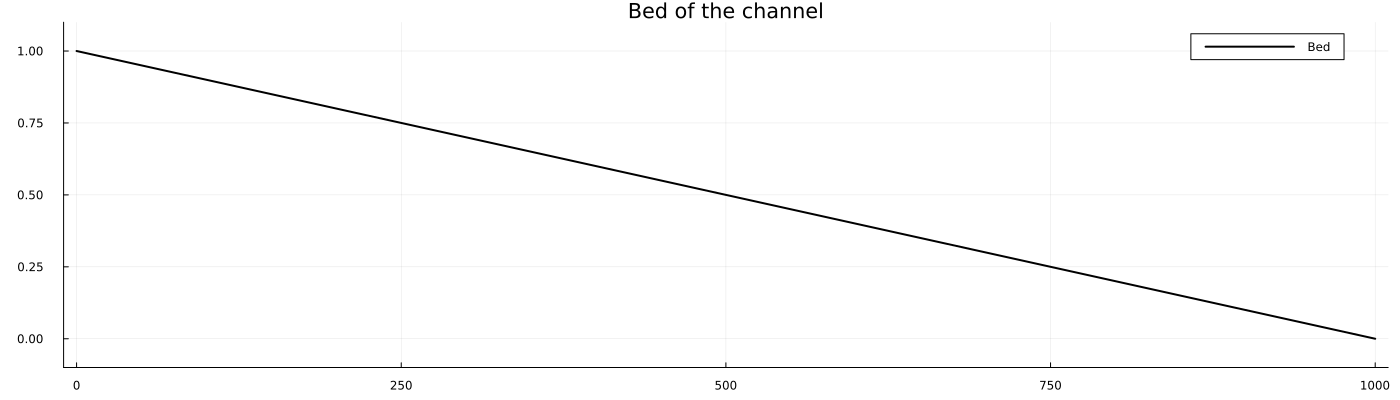

Number of points in channel 1 is 101
x: LinRange{Float64}(0.0, 1000.0, 101)
Uniform depths: [0.33153635556900923] m
first and last x coordinates: 0.0 m, 1000.0 m
first and last z coordinates: 1.0 m, 0.0 m


In [ ]:
# Build the geometry and define the $dx$;

@views function evaluate_uniform_depth(Q, B, L, Ks, iF)
    # Find the normal depth from the formula above, it is an implicit formula, so adopt an iterative procedure:
    Qnew = 0.0; tol = 1.0e-4; res = 0.1; n = 0; d = 1.0; # initial guess for the depth [m]
    initial_res = Q - B * d * Ks * ((B * d)/(2*d + B))^(2/3) * iF^(1/2);
    while abs(res) >= tol 
        Qnew = B * d * Ks * ((B * d)/(2*d + B))^(2/3) * iF^(1/2)
        res = Q - Qnew;
        increment = res/initial_res*0.1;
        if res > 0 # so the depth is too small
            d += increment; # increase the depth
        else
            d -= increment; # decrease the depth
        end
        n += 1
    end

    #= 
    println("Normal depth: ", d, " m, after ", n, " iterations.")
    println("Residual: ", res, " m^3/s, Discarge QNew: ", Qnew, " m^3/s")
    Yu = (Q/(B * Ks * iF^(1/2)))^(3/5)
    println("Normal depth WRC: ", Yu, " m")
    =#
    return d
end #function

@views function build_bed!(z, x, dx, iF, n_points)
    # build the bed of the channel, the idea is to have always positive z coordinates, and locate
    # the zero of the x coordinate at the most upstream point of the channel
    dz_tot = x[end] * iF            # total z coordinate at the end of the channel, it is a linear function of x
    for n in 1:n_points
        z[n] = -iF * x[n] + dz_tot # z coordinate is a linear function of x, with slope iF
    end
    # return z
end


L = [1000.0]        # length of the channel [m]
Q = 20.0            # discharge [m^3/s] Q = Ω Ks R^2/3 iF^1/2
B = [100.0]         # width of the channel [m]
Ks = 40.0           # Strickler coefficient [m^(1/3)/s] Ks = 1/n
iF = [0.001]        # slope of the channel
dx = 10.0           # distance between the points of the channel [m]


n_segments = 1 # number of segments of the channel (with different slopes)
d_uniform = Array{Float64}(undef, n_segments) # array to store the uniform depths
X = Float64[] # x coordinates of the points in the channel
Z = Float64[] # z coordinates of the points in the channel
for n in 1:n_segments
    d_uniform[n] = evaluate_uniform_depth(Q, B[n], L[n], Ks, iF[n])
    L[n]%dx ≠ 0 && error("The length of the channel must be a multiple of dx")
    n_points = Int(L[n]/dx) + 1         # number of points in the channel
    println("Number of points in channel ", n, " is ",  n_points)
    x = LinRange(0, L[n], n_points)                     # x coordinates of the points
    println("x: ", x)
    z = zeros(n_points)                 # z coordinates of the points, initially all zero
    build_bed!(z, x, dx, iF[n], n_points) # build the bed of the channel
    X = n == 1 ? x : [X, x]
    Z = n == 1 ? z : [Z, z] # concatenate the arrays for the first segment or the others
end

# The water elevation has no need to be initialized, just the two extreems values for the BC
# The BC are always the uniform flow depth:
α = 1.0 # correction factor for the non prismaticity of the channel
eL = d_uniform[1] + Q^2 / (2 * g * (B[1] * d_uniform[1])^2) # water elevation at the left boundary [begin]
eL = d_uniform[1] + Q^2 / (2 * g * (B[1] * d_uniform[1])^2) # water elevation at the left boundary [end]


println("Uniform depths: ", d_uniform, " m")
println("first and last x coordinates: ", X[begin], " m, ", X[end], " m")
println("first and last z coordinates: ", Z[begin], " m, ", Z[end], " m")

p1 = plot(X, Z, label="Bed", xlabel="x [m]", ylabel="z [m]", title="Bed of the channel", legend=:topright,
    grid=true, xlims=(X[begin]-10, X[end]+10), ylims=(minimum(Z)-0.1, 1.1 * maximum(Z)), color="black", linewidth=2,
    size=(1400, 400))
display(p1)



